In [1]:
# Import the necessary modules

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Increase the number of characters displayed in a Pandas column
pd.options.display.max_colwidth = 400

---

# 03 Exploratory Data Analysis

Now that the data has been scraped and cleaned, the first step would be to analyse the data that we have gathered.  

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

First, I will check the distribution of the target to see if there are imbalanced classes.

In [3]:
# Check the distribution of our target
train.subreddit.value_counts(normalize=True)

0    0.527318
1    0.472682
Name: subreddit, dtype: float64

This shows that we have a fairly even distribution of our target, `subreddit`.

### Numeric features

We will start by exploring the `length` and `num_words` columns for both `title` and `article_text`, which are numeric features.  

We will check if there is an obvious split in `length` and `num_words` which might suggest different classes (subreddits).  

We will also observe the distribution of the data.

In [4]:
train_nums = train[['article_text_num_words','article_text_length','title_num_words','title_length']]

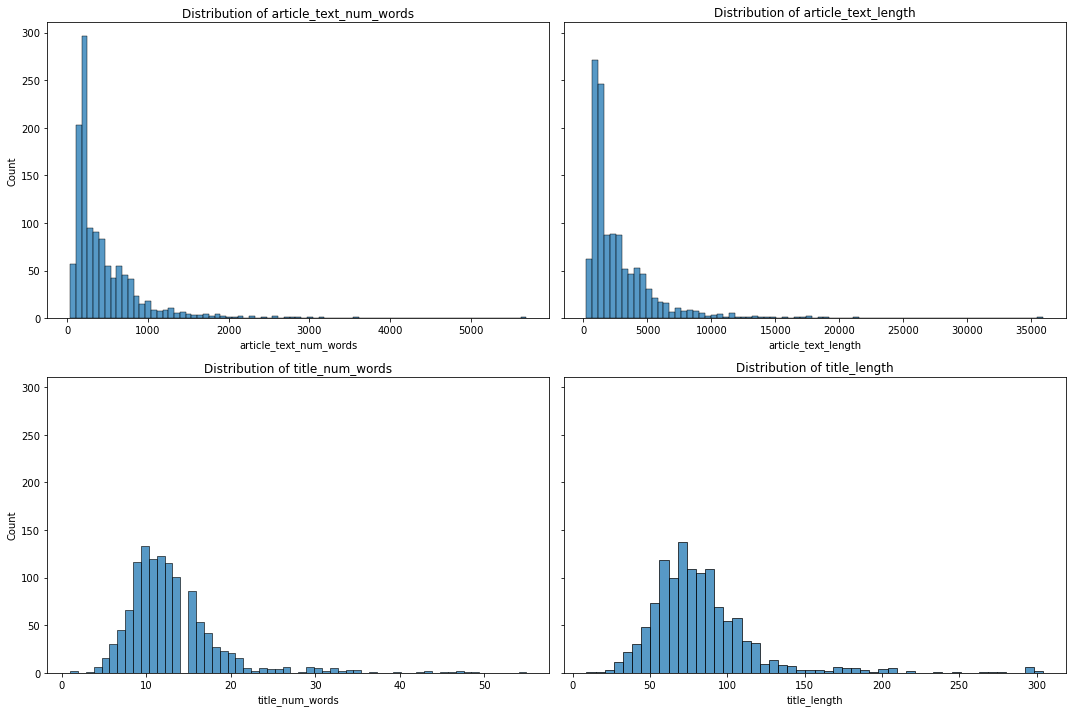

In [5]:
# Plot histograms to identify the distribution of the data
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)
ax = ax.flatten()

for idx, col in enumerate(train_nums.columns):
    sns.histplot(data=train_nums, x=col, ax=ax[idx])
    ax[idx].title.set_text(f'Distribution of {col}')

# Allow the plot to adjust spacing
fig.tight_layout() 

# Save the plot as an image file
plt.savefig(fname='../img/hist.png')


We can see that `article_text_length` and `article_text_num_words` are right-skewed, and although `title_num_words` and `title_length` look normal, we can also see a very long tail to the right for both of them.

There is also a big difference in magnitudes. Hence, if we were to use a kNN clasifier to classify between the two subreddits based on these numerical features, we will have to scale the data to ensure that the magnitudes does not affect the model.  

---

### Text features

Next, we will explore the text columns. In order to do this, we will count-vectorize the text. 

We will then inspect the top 15 words and bigrams in the `title` and `article_text` columns to identify if there are any frequently occurring words which can immediately identify the subreddit it belongs to.

In [6]:
# Instantiate CountVectorizer
cvec = CountVectorizer(max_features=1000, stop_words = 'english')

# Fit and transform the titles of the training set
title_cvec = cvec.fit_transform(train.title)

# Put the transformed titles into a DataFrame
title_df = pd.DataFrame(title_cvec.todense(), columns = cvec.get_feature_names())

# Show the top 15 words
title_df.sum().sort_values(ascending=False)[:15]

covid          75
new            71
trump          63
says           56
biden          53
china          51
man            48
russia         47
19             44
russian        39
india          36
police         36
nation         32
vaccine        32
coronavirus    28
dtype: int64

In [7]:
# Instantiate CountVectorizer for bigrams
cvec2 = CountVectorizer(max_features=1000, stop_words = 'english', ngram_range=(2,2))

# Fit and transform the titles of the training set
title_cvec2 = cvec2.fit_transform(train.title)

# Put the transformed titles into a DataFrame
title_df2 = pd.DataFrame(title_cvec2.todense(), columns = cvec2.get_feature_names())

# Show the top 15 words
title_df2.sum().sort_values(ascending=False)[:15]

covid 19                41
year old                12
white house             12
social media            10
czech republic          10
sanctions russia         9
hong kong                8
19 vaccine               8
raul castro              6
prime minister           6
biden administration     6
supreme court            6
18 russian               6
expels 18                5
climate change           5
dtype: int64

In [8]:
# Instantiate CountVectorizer
cvec3 = CountVectorizer(max_features=1000, stop_words = 'english')

# Fit and transform the article_text of the training set
article_text_cvec3 = cvec3.fit_transform(train.article_text)

# Put the transformed article_text into a DataFrame
article_text_df3 = pd.DataFrame(article_text_cvec3.todense(), columns = cvec3.get_feature_names())

# Show the top 15 words
article_text_df3.sum().sort_values(ascending=False)[:15]

said          3884
people        1222
new           1099
time           996
government     993
year           821
country        819
president      806
just           801
china          778
like           708
russia         645
years          631
russian        619
state          584
dtype: int64

In [9]:
# Instantiate CountVectorizer
cvec4 = CountVectorizer(max_features=1000, stop_words = 'english', ngram_range=(2,2))

# Fit and transform the article_text of the training set
article_text_cvec4 = cvec4.fit_transform(train.article_text)

# Put the transformed article_text into a DataFrame
article_text_df4 = pd.DataFrame(article_text_cvec4.todense(), columns = cvec4.get_feature_names())

# Show the top 15 words
article_text_df4.sum().sort_values(ascending=False)[:15]

covid 19          398
united states     293
press time        288
year old          211
prime minister    181
social media      157
human rights      137
joe biden         134
new york          133
white house       132
prince philip     119
donald trump      119
said statement    117
hong kong         111
hide caption      100
dtype: int64

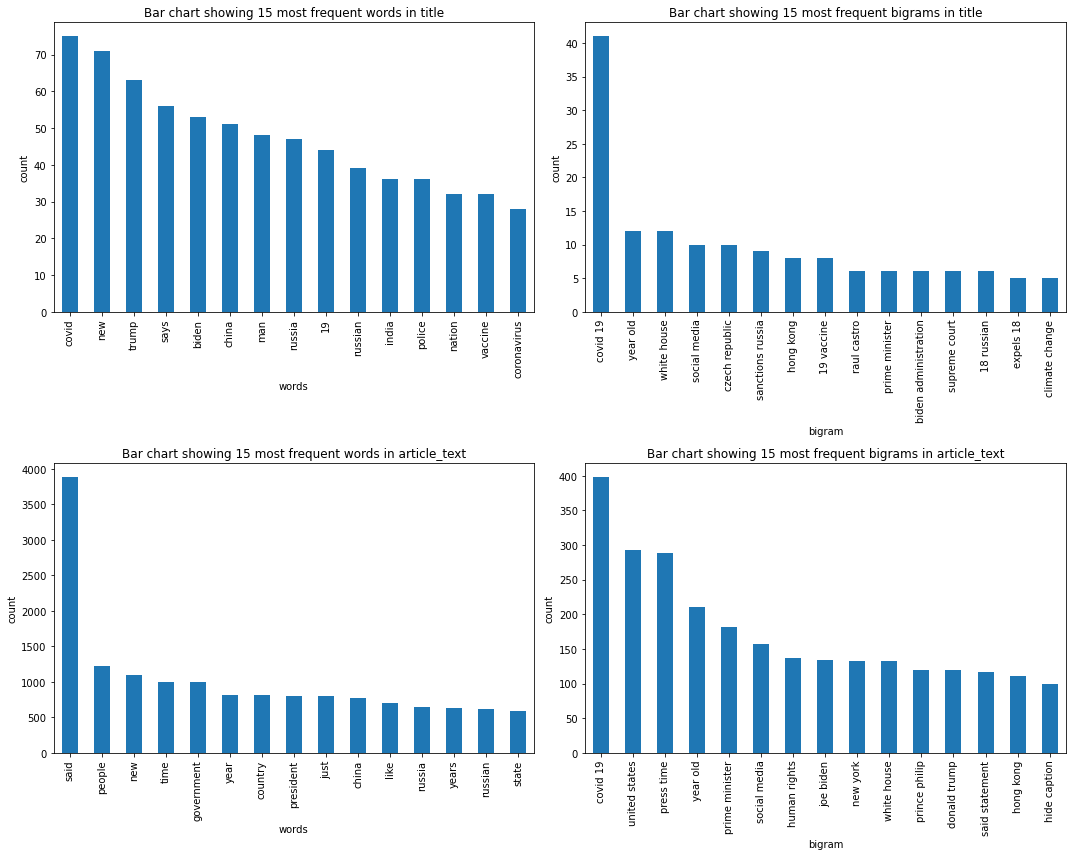

In [10]:
# Instantiate figure and subplots to vizualize the top 15 words and bigrams
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12), sharey=False)
ax = ax.flatten()

# Bar chart for frequent words in title
title_df.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[0]);
ax[0].title.set_text('Bar chart showing 15 most frequent words in title')
ax[0].set_xlabel('words')
ax[0].set_ylabel('count')

# Bar chart for frequent bigrams in title
title_df2.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[1]);
ax[1].title.set_text('Bar chart showing 15 most frequent bigrams in title')
ax[1].set_xlabel('bigram')
ax[1].set_ylabel('count')

# Bar chart for frequent words in article_text
article_text_df3.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[2]);
ax[2].title.set_text('Bar chart showing 15 most frequent words in article_text')
ax[2].set_xlabel('words')
ax[2].set_ylabel('count')

# Bar chart for frequent bigrams in article_text
article_text_df4.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[3]);
ax[3].title.set_text('Bar chart showing 15 most frequent bigrams in article_text')
ax[3].set_xlabel('bigram')
ax[3].set_ylabel('count')

# Allow figure to adjust spacing
fig.tight_layout()

# Save the plots as an image file.
plt.savefig(fname='../img/bar.png')


The most common words and bigrams have some similarities for the `title` column, but is slightly different for the `article_text` column.  

We can see that covid 19 is a hot topic, as well as the big countries like the United States, China, and Russia.  

However, just looking at the words and bigrams on their own, it is difficult to identify which words belong to `WorldNews` and which belong to `TheOnion`.  

We also noticed that there is an imbalance of the most frequent words, hence we will explore TfidfVectorizer.

In [11]:
# Instantiate TfidfVectorizer
tvec = TfidfVectorizer(max_features=1000, stop_words = 'english')

# Fit and transform the titles of the training set
title_tvec = tvec.fit_transform(train.title)

# Put the transformed titles into a DataFrame
title_df = pd.DataFrame(title_tvec.todense(), columns = tvec.get_feature_names())

# Show the top 15 words
title_df.sum().sort_values(ascending=False)[:15]

new            21.812896
covid          20.768888
trump          20.536472
china          17.360015
says           17.143911
biden          17.025684
man            15.683272
russia         15.003652
19             13.107931
nation         12.822960
police         12.769999
russian        11.275411
india          11.138119
coronavirus    10.964454
vaccine        10.506186
dtype: float64

In [12]:
# Instantiate TfidfVectorizer for bigrams
tvec2 = TfidfVectorizer(max_features=1000, stop_words = 'english', ngram_range=(2,2))

# Fit and transform the titles of the training set
title_tvec2 = tvec2.fit_transform(train.title)

# Put the transformed titles into a DataFrame
title_df2 = pd.DataFrame(title_tvec2.todense(), columns = tvec2.get_feature_names())

# Show the top 15 words
title_df2.sum().sort_values(ascending=False)[:15]

covid 19                18.111939
year old                 9.771661
white house              8.950255
social media             6.595883
sanctions russia         5.554930
hong kong                5.262618
supreme court            5.033732
19 vaccine               4.434226
czech republic           4.364128
biden administration     4.024968
ethiopia tigray          4.017866
introduces new           4.000000
climate change           3.822997
cape town                3.679837
study finds              3.354091
dtype: float64

In [13]:
# Instantiate TfidfVectorizer
tvec3 = TfidfVectorizer(max_features=1000, stop_words = 'english')

# Fit and transform the article_text of the training set
article_text_tvec3 = tvec3.fit_transform(train.article_text)

# Put the transformed article_text into a DataFrame
article_text_df3 = pd.DataFrame(article_text_tvec3.todense(), columns = tvec3.get_feature_names())

# Show the top 15 words
article_text_df3.sum().sort_values(ascending=False)[:15]

said             71.211852
time             42.647805
just             38.614631
people           36.599608
new              36.202151
president        33.580321
like             32.958759
press            31.740269
trump            29.440194
advertisement    28.727392
year             27.641007
country          27.456718
government       27.033345
biden            26.818556
russian          25.141672
dtype: float64

In [14]:
# Instantiate TfidfVectorizer
tvec4 = TfidfVectorizer(max_features=1000, stop_words = 'english', ngram_range=(2,2))

# Fit and transform the article_text of the training set
article_text_tvec4 = tvec4.fit_transform(train.article_text)

# Put the transformed article_text into a DataFrame
article_text_df4 = pd.DataFrame(article_text_tvec4.todense(), columns = tvec4.get_feature_names())

# Show the top 15 words
article_text_df4.sum().sort_values(ascending=False)[:15]

press time           96.915943
covid 19             40.888710
year old             33.560054
new york             33.165544
united states        30.226457
told reporters       23.895000
donald trump         23.152776
social media         21.849338
sources confirmed    21.066840
joe biden            19.599395
don know             18.244413
make sure            16.760153
prime minister       16.491687
white house          16.360869
ve got               15.186239
dtype: float64

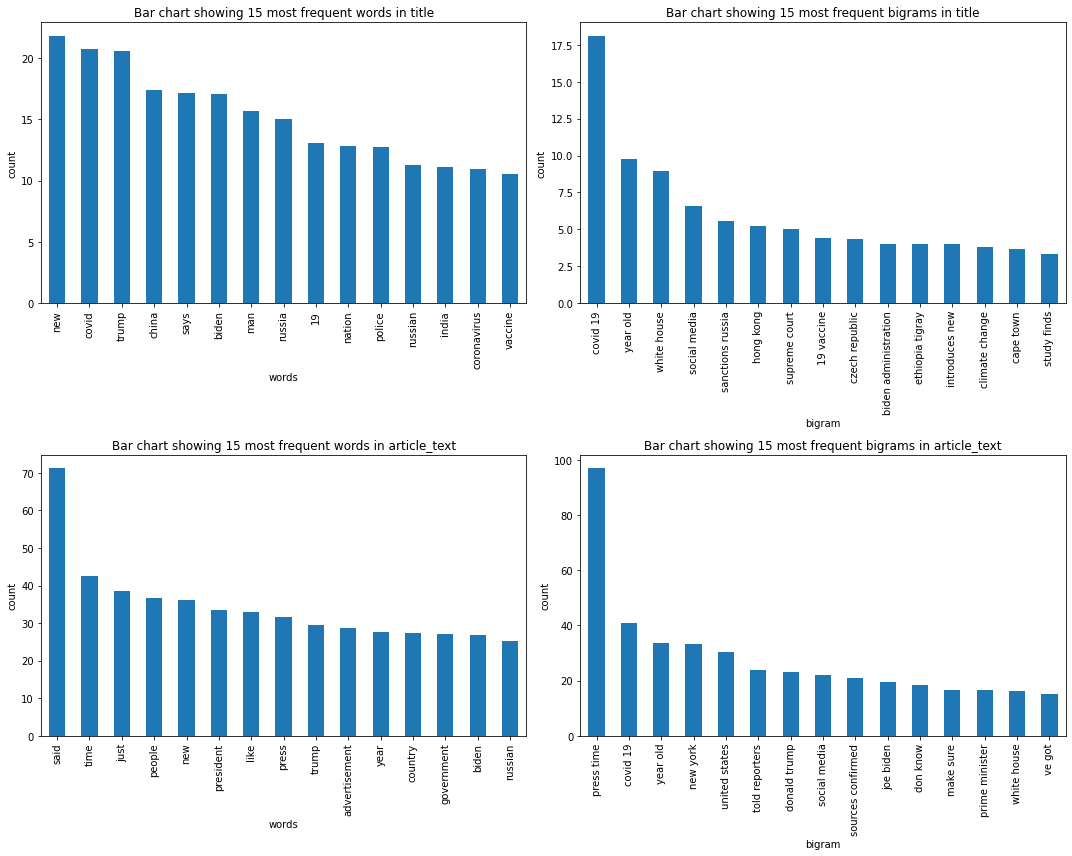

In [15]:
# Instantiate figure and subplots to vizualize the top 15 words and bigrams
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12), sharey=False)
ax = ax.flatten()

# Bar chart for frequent words in title
title_df.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[0]);
ax[0].title.set_text('Bar chart showing 15 most frequent words in title')
ax[0].set_xlabel('words')
ax[0].set_ylabel('count')

# Bar chart for frequent bigrams in title
title_df2.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[1]);
ax[1].title.set_text('Bar chart showing 15 most frequent bigrams in title')
ax[1].set_xlabel('bigram')
ax[1].set_ylabel('count')

# Bar chart for frequent words in article_text
article_text_df3.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[2]);
ax[2].title.set_text('Bar chart showing 15 most frequent words in article_text')
ax[2].set_xlabel('words')
ax[2].set_ylabel('count')

# Bar chart for frequent bigrams in article_text
article_text_df4.sum().sort_values(ascending = False)[:15].plot(kind='bar',ax=ax[3]);
ax[3].title.set_text('Bar chart showing 15 most frequent bigrams in article_text')
ax[3].set_xlabel('bigram')
ax[3].set_ylabel('count')

# Allow figure to adjust spacing
fig.tight_layout()

# Save the plots as an image file.
plt.savefig(fname='../img/bar2.png')


We can see that with TfidfVectorizer, the most common words and bigrams are slightly different, and the disparities have been reduced from 70, 40, 4000, and 400 to around 20, 18, 70, and 100. 

However, it is still not clear which belong to `worldnews` and which belong to `theonion`.